In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, accuracy_score
from scipy import sparse
from lightgbm.sklearn import LGBMClassifier
from scipy.stats import kurtosis
import time
import warnings
import gc
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('./data/train_transaction.csv')

In [47]:
pd.set_option('display.max_columns',1000)
df_train.head(10)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   
5  555.0  150.0        visa  226.0   debit  272.0   87.0   36.0    NaN   
6  360.0  150.0        visa  166.0   debit  126.0   87.0    0.0    NaN   
7  490.0  150.0        visa  226.0   debit  325.0   87.0    NaN    NaN   
8  100.0  150.0        visa  226.0   debit  337.0   87.0    NaN    NaN   
9  111.0  150.0  mastercard  224.0   debit  204.0   87.0   19.0    NaN   

   P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0            NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1      gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2    outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3      yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4      gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
5      gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
6      yahoo.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
7       mail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
8  anonymous.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
9      yahoo.com           NaN  2.0  2.0  0.0  0.0  0.0  3.0  0.0  0.0  3.0   

   C10  C11  C12   C13  C14     D1     D2    D3     D4    D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0    NaN   NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0   94.0   0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    NaN   NaN NaN NaN NaN NaN   
5  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
6  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
7  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
8  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    NaN   NaN NaN NaN NaN NaN   
9  0.0  1.0  0.0  12.0  2.0   61.0   61.0  30.0  318.0  30.0 NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5   0.0    0.0  NaN  NaN  NaN    0.0    T    T    T   M1    F    T  NaN  NaN   
6   0.0    0.0  NaN  NaN  NaN

In [5]:
df_train.shape

(590540, 394)

In [12]:
df_train.describe()

TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06      135.027176   
std     1.704744e+05       0.183755   4.617224e+06      239.162522   
min     2.987000e+06       0.000000   8.640000e+04        0.251000   
25%     3.134635e+06       0.000000   3.027058e+06       43.321000   
50%     3.282270e+06       0.000000   7.306528e+06       68.769000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31937.391000   

               card1          card2          card3          card5  \
count  590540.000000  581607.000000  588975.000000  586281.000000   
mean     9898.734658     362.555488     153.194925     199.278897   
std      4901.170153     157.793246      11.336444      41.244453   
min      1000.000000     100.000000     100.000000     100.000000   
25%      6019.000000     214.000000     150.000000     166.000000   
50%      9678.000000     361.000000     150.000000     226.000000   
75%     14184.000000     512.000000     150.000000     226.000000   
max     18396.000000     600.000000     231.000000     237.000000   

               addr1          addr2          dist1         dist2  \
count  524834.000000  524834.000000  238269.000000  37627.000000   
mean      290.733794      86.800630     118.502180    231.855423   
std       101.741072       2.690623     371.872026    529.053494   
min       100.000000      10.000000       0.000000      0.000000   
25%       204.000000      87.000000       3.000000      7.000000   
50%       299.000000      87.000000       8.000000     37.000000   
75%       330.000000      87.000000      24.000000    206.000000   
max       540.000000     102.000000   10286.000000  11623.000000   

                  C1             C2             C3             C4  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean       14.092458      15.269734       0.005644       4.092185   
std       133.569018     154.668899       0.150536      68.848459   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         3.000000       3.000000       0.000000       0.000000   
max      4685.000000    5691.000000      26.000000    2253.000000   

                  C5             C6             C7             C8  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        5.571526       9.071082       2.848478       5.144574   
std        25.786976      71.508467      61.727304      95.378574   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000       0.000000       0.000000   
50%         0.000000       1.000000       0.000000       0.000000   
75%         1.000000       2.000000       0.000000       0.000000   
max       349.000000    2253.000000    2255.000000    3331.000000   

                  C9            C10            C11            C12  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        4.480240       5.240343      10.241521       4.076227   
std        16.674897      95.581443      94.336292      86.666218   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       0.000000   
50%         1.000000       0.000000       1.000000       0.000000   
75%         2.000000       0.000000       2.000000       0.000000   
max       210.000000    3257.000000    3188.000000    3188.000000   

                 C13            C14             D1             D2  \
count  590540.000000  590540.000000  589271.000000  309743.000000   
mean       32.539918       8.295215      94.347568     169.563231   
std       129.364844      49.544262     157.660387     177.315865   

In [13]:
df_train_id = pd.read_csv('./data/train_identity.csv')

In [15]:
df_train_id.shape

(144233, 41)

In [24]:
df_train_id.describe()

TransactionID          id_01          id_02         id_03  \
count   1.442330e+05  144233.000000  140872.000000  66324.000000   
mean    3.236329e+06     -10.170502  174716.584708      0.060189   
std     1.788496e+05      14.347949  159651.816856      0.598231   
min     2.987004e+06    -100.000000       1.000000    -13.000000   
25%     3.077142e+06     -10.000000   67992.000000      0.000000   
50%     3.198818e+06      -5.000000  125800.500000      0.000000   
75%     3.392923e+06      -5.000000  228749.000000      0.000000   
max     3.577534e+06       0.000000  999595.000000     10.000000   

              id_04          id_05          id_06        id_07        id_08  \
count  66324.000000  136865.000000  136865.000000  5155.000000  5155.000000   
mean      -0.058938       1.615585      -6.698710    13.285354   -38.600388   
std        0.701015       5.249856      16.491104    11.384207    26.084899   
min      -28.000000     -72.000000    -100.000000   -46.000000  -100.000000   
25%        0.000000       0.000000      -6.000000     5.000000   -48.000000   
50%        0.000000       0.000000       0.000000    14.000000   -34.000000   
75%        0.000000       1.000000       0.000000    22.000000   -23.000000   
max        0.000000      52.000000       0.000000    61.000000     0.000000   

              id_09         id_10          id_11          id_13         id_14  \
count  74926.000000  74926.000000  140978.000000  127320.000000  80044.000000   
mean       0.091023     -0.301124      99.745325      48.053071   -344.507146   
std        0.983842      2.789446       1.127602      11.774858     93.695502   
min      -36.000000   -100.000000      90.000000      10.000000   -660.000000   
25%        0.000000      0.000000     100.000000      49.000000   -360.000000   
50%        0.000000      0.000000     100.000000      52.000000   -300.000000   
75%        0.000000      0.000000     100.000000      52.000000   -300.000000   
max       25.000000      0.000000     100.000000      64.000000    720.000000   

               id_17         id_18          id_19          id_20        id_21  \
count  139369.000000  45113.000000  139318.000000  139261.000000  5159.000000   
mean      189.451377     14.237337     353.128174     403.882666   368.269820   
std        30.375360      1.561302     141.095343     152.160327   198.847038   
min       100.000000     10.000000     100.000000     100.000000   100.000000   
25%       166.000000     13.000000     266.000000     256.000000   252.000000   
50%       166.000000     15.000000     341.000000     472.000000   252.000000   
75%       225.000000     15.000000     427.000000     533.000000   486.500000   
max       229.000000     29.000000     671.000000     661.000000   854.000000   

             id_22        id_24        id_25        id_26         id_32  
count  5169.000000  4747.000000  5132.000000  5163.000000  77586.000000  
mean     16.002708    12.800927   329.608924   149.070308     26.508597  
std       6.897665     2.372447    97.461089    32.101995      3.737502  
min      10.000000    11.000000   100.000000   100.000000      0.000000  
25%      14.000000    11.000000   321.000000   119.000000     24.000000  
50%      14.000000    11.000000   321.000000   149.000000     24.000000  
75%      14.000000    15.000000   371.000000   169.000000     32.000000  
max      44.000000    26.000000   548.000000   216.000000     32.000000

In [16]:
df_train_id.head(10)

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   
5        2987017   -5.0   61141.0    3.0    0.0    3.0    0.0    NaN    NaN   
6        2987022  -15.0       NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7        2987038    0.0   31964.0    0.0    0.0    0.0  -10.0    NaN    NaN   
8        2987040  -10.0  116098.0    0.0    0.0    0.0    0.0    NaN    NaN   
9        2987048   -5.0  257037.0    NaN    NaN    0.0    0.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN   
1    NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN   
2    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN   
3    NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN   
4    0.0    0.0  100.0  NotFound    NaN -300.0  Found     Found  166.0   15.0   
5    3.0    0.0  100.0  NotFound   52.0 -300.0  Found     Found  166.0   18.0   
6    NaN    NaN    NaN  NotFound   14.0    NaN    NaN       NaN    NaN    NaN   
7    0.0    0.0  100.0     Found    NaN -300.0  Found     Found  166.0   15.0   
8    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN   
9    NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28  \
0  542.0  144.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  621.0  500.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
2  410.0  142.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
3  176.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
4  529.0  575.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
5  529.0  600.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
6    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   NaN    NaN   
7  352.0  533.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
8  410.0  142.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
9  484.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   

      id_29             id_30                id_31  id_32      id_33  \
0  NotFound       Android 7.0  samsung browser 6.2   32.0  2220x1080   
1  NotFound        iOS 11.1.2   mobile safari 11.0   32.0   1334x750   
2     Found               NaN          chrome 62.0    NaN        NaN   
3  NotFound               NaN          chrome 62.0    NaN        NaN   
4     Found  Mac OS X 10_11_6          chrome 62.0   24.0   1280x800   
5     Found        Windows 10          chrome 62.0   24.0   1366x768   
6       NaN               NaN                  NaN    NaN        NaN   
7     Found           Android          chrome 62.0   32.0  1920x1080   
8     Found               NaN          chrome 62.0    NaN        NaN   
9  NotFound               NaN          chrome 62.0    NaN        NaN   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0  match_status:2     T     F     T     T     mobile   
1  match_status:1     T     F     F     T     mobile   
2             NaN     F     F     T     T    desktop   
3             NaN     F     F     T     T    desktop   
4  match_status:2     T     F     T     T    desktop   
5  match_status:2     T     F     T     T    desktop   
6             NaN   NaN   NaN   NaN   NaN        NaN   
7  match_status:2     T     F     T     T     mobile   
8             NaN     F     F     T     T    desktop   
9             NaN     F     F     T     T    desktop   

                      Devic

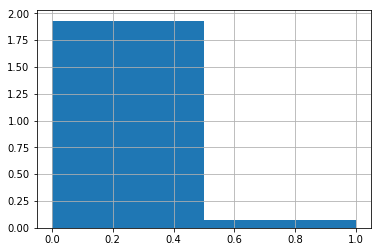

In [23]:
df_train.isFraud.hist(density=True,bins =2)

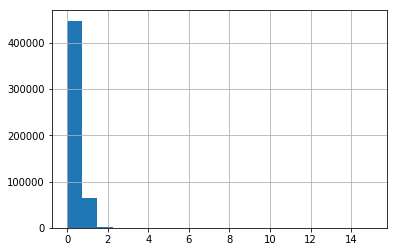

In [45]:
df_train['V17'].hist(bins=20)